In [2]:
import json
from shapely.geometry import Point, LineString

import matplotlib.pyplot as plt

import gbbox

In [5]:
# temporary download link
# https://extract.bbbike.org/?sw_lng=37.417&sw_lat=55.777&ne_lng=37.604&ne_lat=55.886&format=geojson.xz&coords=37.417%2C55.777%7C37.604%2C55.782%7C37.602%2C55.886%7C37.42%2C55.885&city=voikovskaya_bigger

with open('../../Downloads/planet_37.417_55.777_9c495dec.osm.geojson', 'r') as f:
    geojson = json.loads(f.read())

In [6]:
def closest_distance(coords, lines_array):
    return min([get_distance(coords, line) for line in lines_array])

In [7]:
def get_distance(coords, line):
    point = Point(coords)
    line = LineString(road['geometry']['coordinates'])
    dist = point.distance(line)
    
    return dist

In [8]:
def get_objects(data, prop, values=None):
    if not values:
        res = [d for d in data if d['properties'].get(prop, None) != 'mall']
    elif type(values) == list:
        res = [d for d in data if d['properties'].get(prop, None) in values]
    else:
        res = [d for d in data if d['properties'].get(prop, None) == values]
        
    print('objects found', len(res), prop, values)
    return res

In [9]:
data = geojson['features']

In [10]:
objects = {
    'roads': get_objects(data, 'highway', ['primary', 'secondary', 'tertiary', 'road']),
    'water': get_objects(data, 'natural', 'water'),
    'parks': get_objects(data, 'leisure', 'park'),
    'railways': get_objects(data, 'railway', ['rail', 'tram']),
    'malls': get_objects(data, 'shop', 'mall'),
    'shop': get_objects(data, 'shop'),
    'metro': get_objects(data, 'railway', 'subway_entrance')
}

objects found 2503 highway ['primary', 'secondary', 'tertiary', 'road']
objects found 172 natural water
objects found 320 leisure park
objects found 817 railway ['rail', 'tram']
objects found 82 shop mall
objects found 146097 shop None
objects found 131 railway subway_entrance


In [45]:
def refresh_bbox(bbox, x, y):
    if x < bbox['xmin']:
        bbox['xmin'] = x
    elif x > bbox['xmax']:
        bbox['xmax'] = x

    if y < bbox['ymin']:
        bbox['ymin'] = y
    elif y > bbox['ymax']:
        bbox['ymax'] = y        

In [82]:
def get_bbox(geojson):
    if len(geojson['features']) == 0:
        raise ValueError('empty geoJSON passed')
        
    x, y = geojson['features'][0]['geometry']['coordinates']
    
    bbox = {
        'xmin': x,
        'xmax': x,
        'ymin': y,
        'ymax': y,
    }
    
    for obj in geojson['features']:
        if obj['geometry']['type'] == 'Point':
            x, y = obj['geometry']['coordinates']
            refresh_bbox(bbox, x, y)
            
        elif obj['geometry']['type'] == 'LineString':
            for coords in obj['geometry']['coordinates']:
                x, y = coords
                refresh_bbox(bbox, x, y)
                
        elif obj['geometry']['type'] == 'MultiPolygon':
            for poly in obj['geometry']['coordinates'][0]:
                for coords in poly:
                    x, y = coords
                    refresh_bbox(bbox, x, y)

            
    return bbox

In [83]:
get_bbox(geojson)

{'xmax': 37.6039691,
 'xmin': 37.4170148,
 'ymax': 55.8859776,
 'ymin': 55.7770697}

In [27]:
data[0]

{'geometry': {'coordinates': [37.5441842, 55.8822545], 'type': 'Point'},
 'properties': {'highway': 'traffic_signals'},
 'type': 'Feature'}

In [5]:
types = {d['geometry']['type'] for d in data}

In [6]:
types

{'LineString', 'MultiPolygon', 'Point'}

In [7]:
data[:10]

[{'geometry': {'coordinates': [37.5441842, 55.8822545], 'type': 'Point'},
  'properties': {'highway': 'traffic_signals'},
  'type': 'Feature'},
 {'geometry': {'coordinates': [37.5480305, 55.8738526], 'type': 'Point'},
  'properties': {'highway': 'traffic_signals'},
  'type': 'Feature'},
 {'geometry': {'coordinates': [37.526547, 55.8748715], 'type': 'Point'},
  'properties': {'highway': 'traffic_signals'},
  'type': 'Feature'},
 {'geometry': {'coordinates': [37.4698123, 55.8756144], 'type': 'Point'},
  'properties': {'highway': 'traffic_signals', 'source': 'Survey 2015-06-08'},
  'type': 'Feature'},
 {'geometry': {'coordinates': [37.4595645, 55.8715985], 'type': 'Point'},
  'properties': {'highway': 'traffic_signals'},
  'type': 'Feature'},
 {'geometry': {'coordinates': [37.4854466, 55.8582196], 'type': 'Point'},
  'properties': {'highway': 'traffic_signals'},
  'type': 'Feature'},
 {'geometry': {'coordinates': [37.4674265, 55.874764], 'type': 'Point'},
  'properties': {'highway': 'traf

In [33]:
# roads = [d for d in data if d['properties'].get('highway', None) == 'primary']
# len(roads)

In [25]:
roads = [d for d in data if d['properties'].get('highway', None) in ['primary', 'secondary', 'tertiary', 'road']]
len(roads)

2503

In [26]:
water = [d for d in data if d['properties'].get('natural', '111') == 'water']
len(water)

172

In [32]:
roads[0]

{'geometry': {'coordinates': [[37.579704, 55.8100963],
   [37.5796416, 55.8102105]],
  'type': 'LineString'},
 'properties': {'highway': 'primary',
  'lanes': '3',
  'lit': 'yes',
  'maxheight': '4.5',
  'name': 'Дмитровское шоссе',
  'name:be': 'Дзмітраўская шаша',
  'oneway': 'yes',
  'surface': 'asphalt'},
 'type': 'Feature'}

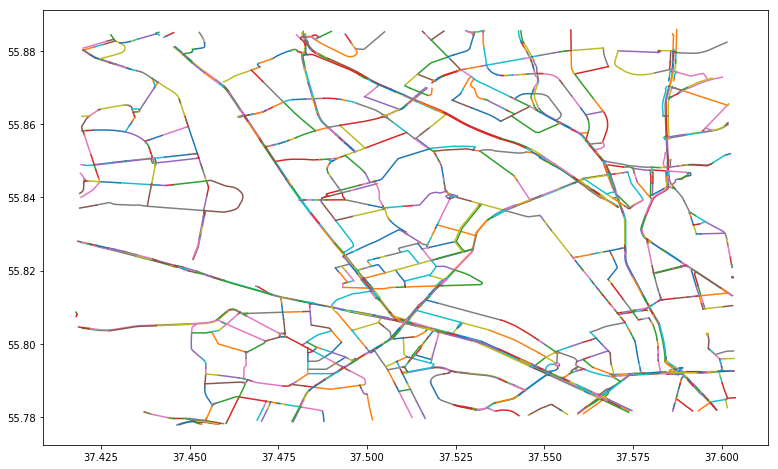

In [19]:
fig = plt.figure(figsize = (13, 8))

for road in roads:
    xvals = [coord[0] for coord in road['geometry']['coordinates'] if len(coord) == 2]
    yvals = [coord[1] for coord in road['geometry']['coordinates'] if len(coord) == 2]

    plt.plot(xvals, yvals)

In [151]:
#  https://tools.ietf.org/html/rfc7946#page-8
#  F(lon, lat) = (lon0 + (lon1 - lon0) * t, lat0 + (lat1 - lat0) * t)

In [23]:
closest_distance((0,0), roads)

67.20993275573797

In [177]:
# data

In [24]:
zz = [d for d in data if 'highway' in d['properties']]
hw_vals = {z['properties']['highway'] for z in zz}
hw_vals

{'bus_stop',
 'construction',
 'crossing',
 'cycleway',
 'elevator',
 'fake_speed_camera',
 'footway',
 'give_way',
 'living_street',
 'mini_roundabout',
 'motorway_junction',
 'path',
 'pedestrian',
 'planned',
 'platform',
 'primary',
 'primary_link',
 'proposed',
 'residential',
 'road',
 'secondary',
 'secondary_link',
 'service',
 'services',
 'speed_camera',
 'steps',
 'stop',
 'street_lamp',
 'tertiary',
 'tertiary_link',
 'track',
 'traffic_mirror',
 'traffic_signals',
 'trunk',
 'trunk_link',
 'turning_circle',
 'unclassified'}

In [90]:
# road
# water
# park
# railway
# shoping_mall
# produktoviy
# metro station + rw station
# business center
# school etc

In [141]:
# from shapely.geometry import LineString
# from math import radians, cos, sin, asin, sqrt

# # Calculates distance between 2 GPS coordinates
# def haversine(lat1, lon1, lat2, lon2):
#     """
#     Calculate the great circle distance between two points 
#     on the earth (specified in decimal degrees)
#     """
#     # convert decimal degrees to radians 
#     lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

#     # haversine formula 
#     dlon = lon2 - lon1 
#     dlat = lat2 - lat1 
#     a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
#     c = 2 * asin(sqrt(a)) 
#     r = 3956 # Radius of earth in kilometers. Use 3956 for miles
#     return c * r

In [149]:
# def law_cos(point1, point2):
#     distance = math.acos(math.sin(math.radians(point1.y))*math.sin(math.radians(point2.y))+math.cos(math.radians(point1.y))*math.cos(math.radians(point2.y))*math.cos(math.radians(point2.x)-math.radians(point1.x)))*6371

In [37]:
names = [d['properties']['name'] for d in data if 'name' in d['properties']]

In [38]:
names

['ЕКА',
 'Газпромнефть',
 'Лукойл',
 'Газпромнефть',
 'Роснефть',
 'Москва',
 'Тимирязевская',
 'Дегунино',
 'Москва-Савёловская',
 'Савёловская',
 'Окружная',
 'Тимирязевская',
 'Улица Милашенкова',
 'Ашан Сити',
 'Бульвар Яна Райниса, 31',
 'Улица Героев Панфиловцев, д. 21',
 'Планерная улица',
 'Алёшкино',
 'Аллея "Дорога Жизни"',
 'Детская поликлиника',
 'Станция метро "Щукинская"',
 'Улица Берзарина',
 'Улица Авиаконструктора Микояна, 14',
 'ПивКо',
 'Ленинградская',
 'Лихоборы',
 'Гражданская',
 'Речной вокзал',
 'Водный стадион',
 'Войковская',
 'Сокол',
 'Аэропорт',
 'Динамо',
 'ВкусВилл',
 '19-й микрорайон',
 'Лукойл',
 'Метро Верхние Лихоборы',
 'Киномакс XL',
 'Тимирязевская',
 'Дмитровская',
 'Савёловская',
 'Планерная',
 'Тушинская',
 'Щукинская',
 'Владыкино',
 'Молочно-раздаточный пункт №3 (при ДГП №94 филиал №1)',
 'Канал имени\xa0Москвы',
 'Эрнсту Тельману',
 'Роснефть',
 'ТНК',
 'Shell',
 'Метро «Щукинская»',
 'Газпромнефть',
 'МТК',
 'Покровское-Стрешнево',
 'ТрансАЗ

In [117]:
temp = [d for d in data if 'метро' in d['properties'].get('name', '111') and d['properties'].get('highway', '123') in ['123', 'bus_stop']]

In [62]:
temp = [d for d in data if d['properties'].get('shop', '111') == 'mall']

In [1]:
# import geopandas as gpd
# df = gpd.read_file('../../Downloads/planet_37.487_55.81_f6f462c0.osm.geojson')
# df.shape

(3904, 279)

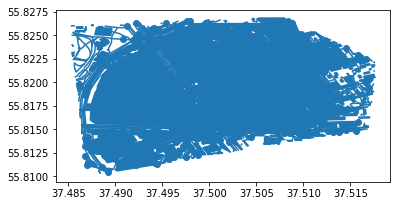

In [3]:
# df.plot()

In [13]:
# df['name:ru'].dropna()

14                     Войковская
33                    Перекресток
34                  Ароматный мир
38                    Бургер Кинг
49                       IL Патио
59                         Воккер
68                        Теремок
71                Крошка Картошка
132                    Райффайзен
203                      Старбакс
213                   Шоколадница
231                      Горздрав
243                      Горздрав
248                      Горздрав
251                         Дикси
270                      Сбербанк
310                         Сплав
375                           ВТБ
380                      У Палыча
387                    Альфа-Банк
393             Пригородная касса
403                      Магнолия
404                         Джерк
407                       Связной
420      ЗАО "Хьюлетт-Паккард АО"
423                         Дикси
428                       Сова Бу
431                     Пятёрочка
434                      Горздрав
435           